# Simple projectile motion in PyMC
Uncertainty in initial angle -> uncertainty in position

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
n_devices = 16
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(n_devices)
os.environ['JAX_PLATFORMS'] = 'cpu'  # BlackJAX NUTS sampler seems to have issues with JAX

In [4]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd

Model: projectile motion with an initial angle between 0 and $\pi/2$ and velocity $v_0$.

The impact distance is given by $x = v_0/g*\sin(2\theta)$

Note that we need to add a random variable $x_{obs}$ for observed impact point if we would like to infer
unknown $v_0$ and $\theta$.  See [Observed Deterministic](https://discourse.pymc.io/t/observed-deterministic/483) thread on the
PyMC discourse for reasons why we can't just observe $x$.

In [5]:
with pm.Model() as model:
    theta_scaled = pm.Beta('theta_scaled', 1, 1)
    theta = pm.Deterministic('theta', theta_scaled * np.pi/2)
    v0 = pm.Normal('v0', 10, 1)
    g = pm.Data('g', 9.8)
    x = pm.Deterministic('x', v0**2 / g * np.sin(2*theta))
    x_obs = pm.Normal('x_obs', x, 0.2)

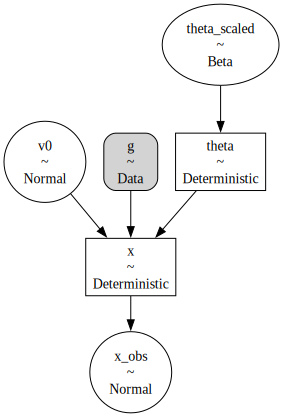

In [6]:
pm.model_to_graphviz(model)

In [7]:
# Draws from prior distribution
pm.draw([model['theta'], model['x'], model['x_obs']], 10)

[array([0.18506534, 0.39900995, 0.4457605 , 0.58788888, 0.04893465,
        1.36133758, 0.76443428, 0.62468608, 0.90093718, 0.51280065]),
 array([ 2.53000163,  9.81464143,  5.56649511,  9.62685314,  1.08850419,
         4.89423184, 10.80728262,  9.23240917,  9.63331308, 10.35925014]),
 array([ 2.34591383,  9.89000293,  5.94572846,  9.78264497,  1.21833989,
         4.90748274, 10.82664223,  9.87023671,  9.43855692, 10.76798334])]

Simulation model with known fixed vales of v0 and theta

In [8]:
sim_model = pm.do(model, {'v0': 10, 'theta_scaled': 0.5})

In [9]:
# Draws from the fixed parameter model
pm.draw([sim_model['x'], sim_model['x_obs']], 10)

[array([10.20408163, 10.20408163, 10.20408163, 10.20408163, 10.20408163,
        10.20408163, 10.20408163, 10.20408163, 10.20408163, 10.20408163]),
 array([10.18240427, 10.38269631, 10.41594868, 10.36711739, 10.33350979,
        10.19511946, 10.08294948, 10.3101715 ,  9.97834325, 10.19552394])]

In [10]:
# Compare with expected result
10**2/9.8*np.sin(2*np.pi*0.25)

10.204081632653061

Model for inference from observed distance

In [11]:
data_model = pm.observe(model, {'x_obs': 10.2})  # theta = pi/4 i.e. theta_scaled = 0.5

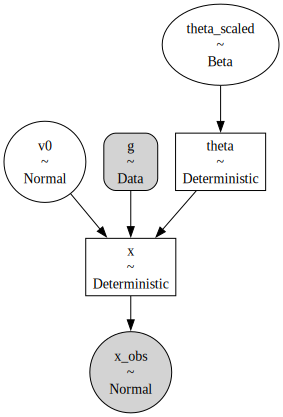

In [12]:
pm.model_to_graphviz(data_model)

In [13]:
with data_model:
    idata = pm.sample(5000, random_seed=42, nuts_sampler='blackjax', chains=n_devices, progressbar=False, target_accept=0.95)

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.785,0.203,0.439,1.137,0.002,0.001,7073.0,8947.0,1.0
theta_scaled,0.500,0.129,0.279,0.724,0.001,0.001,7073.0,8947.0,1.0
v0,10.452,0.515,9.810,11.449,0.005,0.006,11316.0,10598.0,1.0
x,10.187,0.199,9.806,10.556,0.001,0.001,62532.0,52881.0,1.0


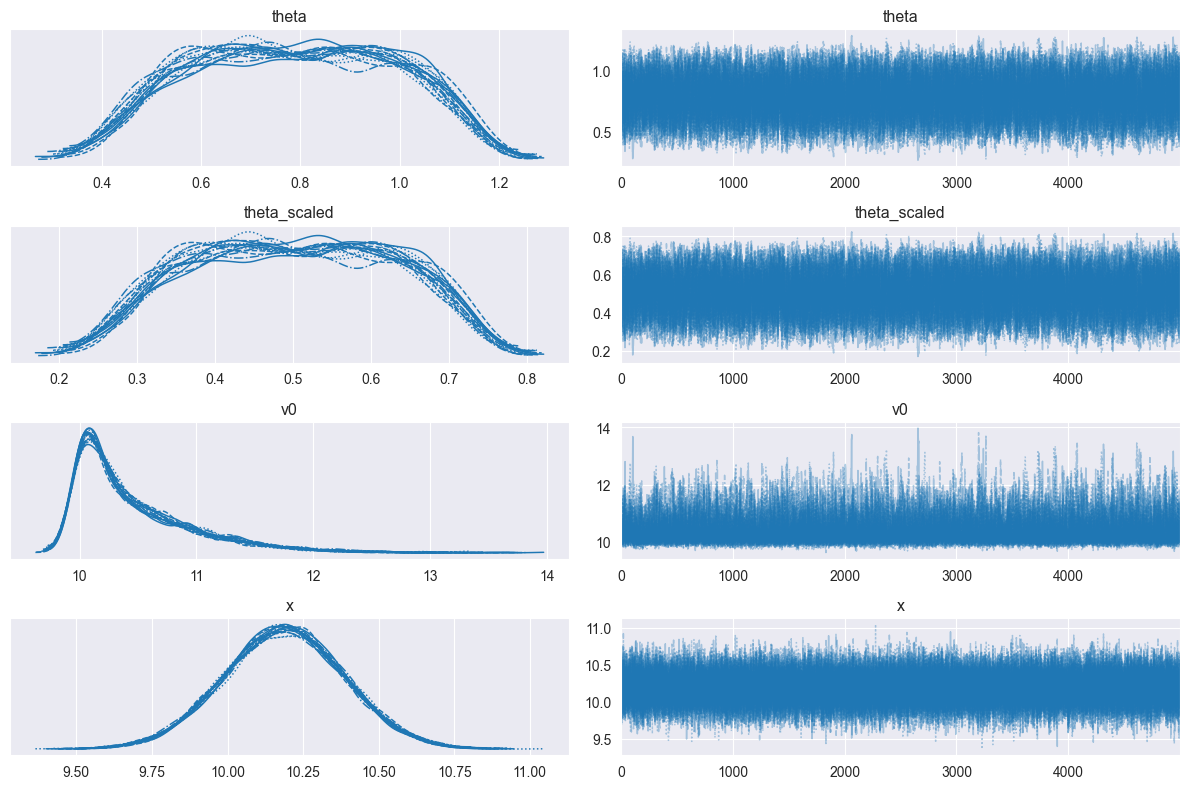

In [15]:
az.plot_trace(idata)
plt.tight_layout()

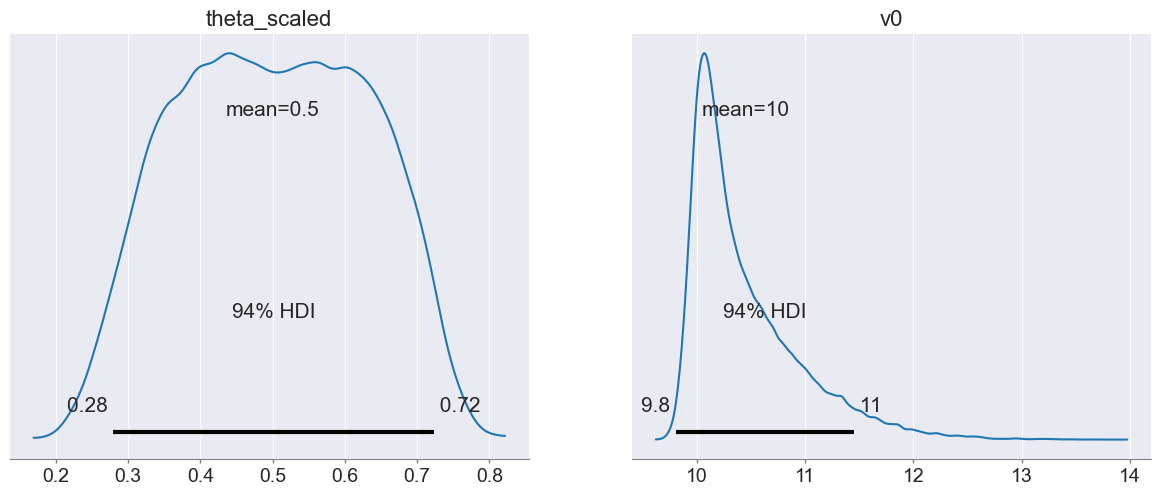

In [16]:
_ = az.plot_posterior(idata, ['theta_scaled', 'v0'])

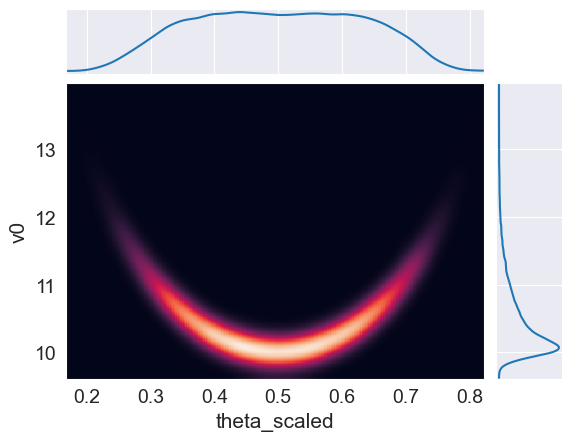

In [17]:
_ = az.plot_pair(idata, var_names=['theta_scaled', 'v0'], marginals=True, kind='kde', kde_kwargs=dict(contour=False))

If we observe an $x_{obs}$ that could have two possible angles given the prior on $v0$ do we infer both angles?

In [18]:
data_model2 = pm.observe(model, {'x_obs': 7., })  # Two possible solutions

In [19]:
with data_model2:
    idata2 = pm.sample(
        5000, random_seed=42, nuts_sampler='blackjax', chains=n_devices,
        progressbar=False, target_accept=0.99
    )

In [20]:
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.792,0.357,0.288,1.282,0.006,0.001,3552.0,7637.0,1.0
theta_scaled,0.504,0.228,0.183,0.816,0.004,0.001,3552.0,7637.0,1.0
v0,9.640,0.934,8.168,11.258,0.010,0.007,9938.0,9934.0,1.0
x,7.005,0.199,6.618,7.369,0.001,0.001,56955.0,47090.0,1.0


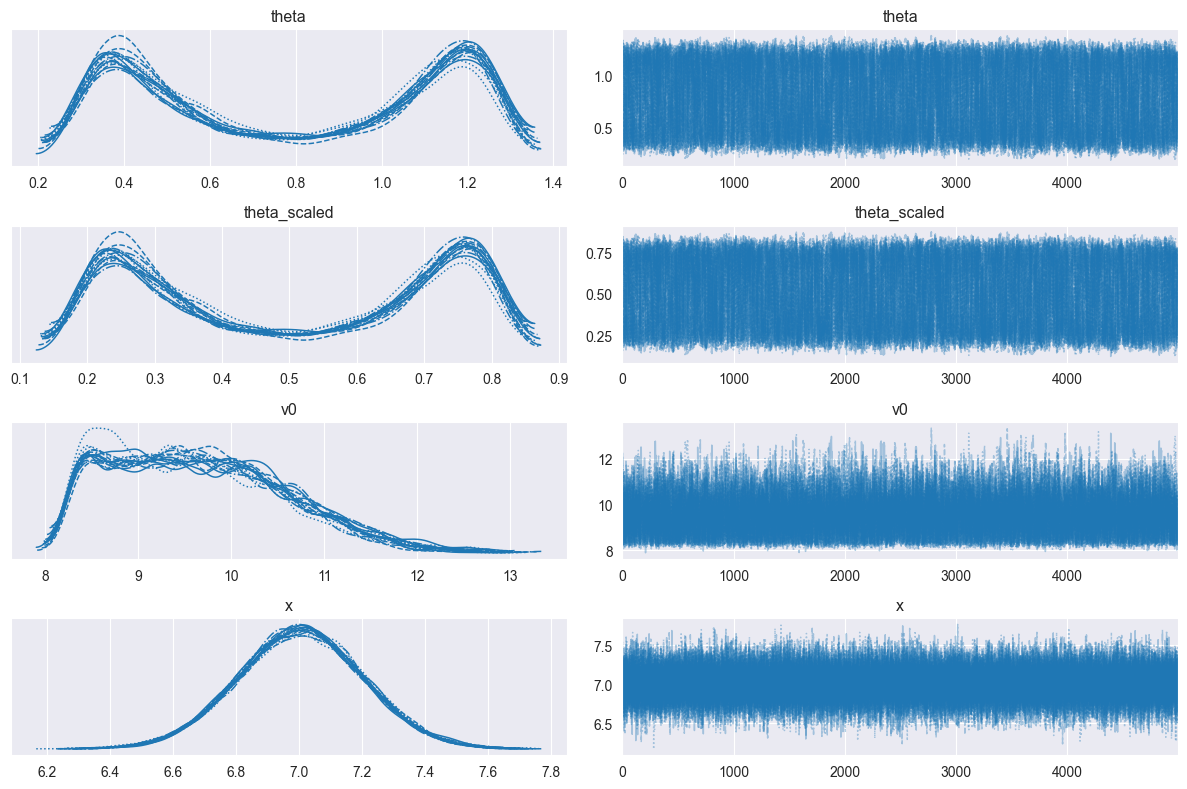

In [21]:
az.plot_trace(idata2)
plt.tight_layout()

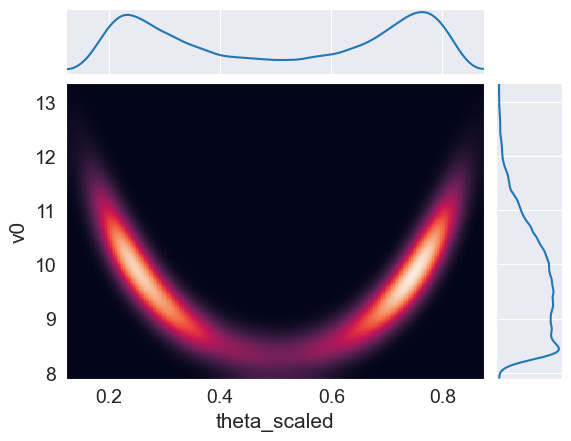

In [22]:
_ = az.plot_pair(idata2, var_names=['theta_scaled', 'v0'], marginals=True, kind='kde', kde_kwargs=dict(contour=False))